In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

# 15. Coal Mining Disasters in the UK*

Adapted from [Unit 5: disastersmc.m](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit5/disastersmc.m).

The 112 data points represent the numbers of coal-mining disasters involving 10 or more men killed per year between 1851 and 1962 ({cite:t}`ukcoaldisasteroriginal`, {cite:t}`ukcoaldisasterupdate`). 

You can check out the derivation of the model we're using on the previous page, or see {cite:t}`carlinchangepoint1992` for the inspiration.

In [2]:
rng = np.random.default_rng(1)

# x is the number of coal mine disasters per year
# fmt: off
x = [4, 5, 4, 1, 0, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6, 3, 3, 5, 4, 5, 3, 1,
     4, 4, 1, 5, 5, 3, 4, 2, 5, 2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3,
     0, 0, 1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1, 0, 1, 0, 1, 0,
     0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2, 3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2,
     0, 0, 0, 1, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
# fmt: on

year = [y for y in range(1851, 1963)]

n = len(x)
obs = 10000
burn = 500

lambdas = np.zeros(obs)
mus = np.zeros(obs)
ms = np.zeros(obs)
posterior_m = np.zeros(n)

# inits
lambdas[0] = 4
mus[0] = 0.5
ms[0] = 10

# hyperparameters
alpha = 4
beta = 1
gamma = 0.5
delta = 1

# sampling
for i in tqdm(range(1, obs)):
    # lambda
    mm = int(ms[i - 1])
    alpha1 = alpha + np.sum(x[: mm + 1])
    beta1 = mm + beta

    lambdas[i] = rng.gamma(alpha1, 1 / beta1)

    # mu
    gamma1 = gamma + np.sum(x) - np.sum(x[: mm + 1])
    delta1 = n - mm + delta

    mus[i] = rng.gamma(gamma1, 1 / delta1)

    # posterior weights
    for j in range(n):
        posterior_m[j] = np.exp((mus[i] - lambdas[i]) * j) * (
            lambdas[i] / mus[i]
        ) ** np.sum(x[: j + 1])
        # normalize to get probabilities
        weights = posterior_m / np.sum(posterior_m)

    ms[i] = rng.choice(range(n), replace=False, p=weights, shuffle=False)

lambdas = lambdas[burn:]
mus = mus[burn:]
ms = ms[burn:]

  0%|          | 0/9999 [00:00<?, ?it/s]

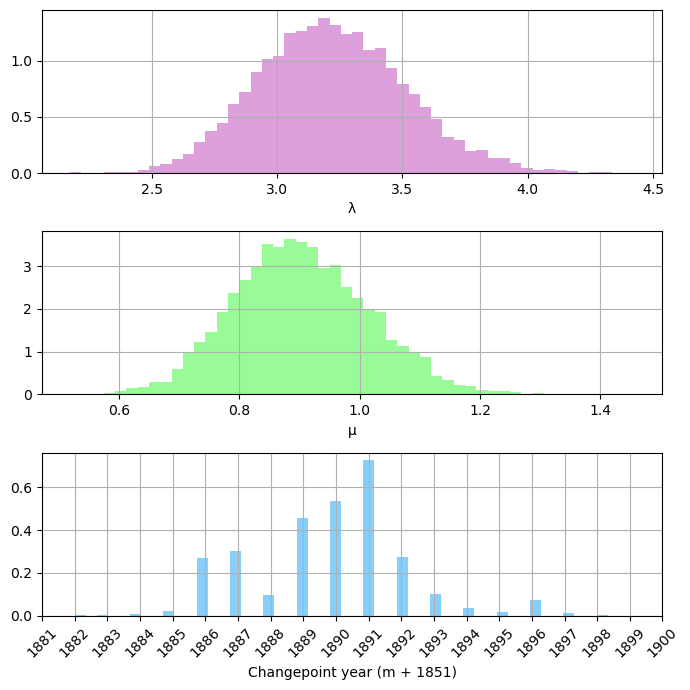

In [11]:
# posterior densities
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 7))

ax1.grid(True)
ax1.hist(lambdas, color="plum", density=True, bins=50)
ax1.set_xlabel("λ")

ax2.grid(True)
ax2.hist(mus, color="palegreen", density=True, bins=50)
ax2.set_xlabel("μ")

ax3.grid(True)
ax3.hist(ms + 1851, color="lightskyblue", density=True, bins=50)
ax3.set_xlabel("Changepoint year (m + 1851)")
plt.xticks(year[30:50], rotation=45)
plt.minorticks_off()

plt.tight_layout()
plt.show()

Let's check the odds ratio as well.

In [32]:
count_m_eq_n = np.sum(ms == n)
prob_m_equals_n = count_m_eq_n / ms.shape[0]
posterior_odds_ratio = prob_m_equals_n / (1 - prob_m_equals_n)

print(f"Posterior odds ratio that m=n: {posterior_odds_ratio:.4f}")

Posterior odds ratio that m=n: 0.0000


There are actually 0 occurrences of $m=n$ in our samples, which is probably why the professor didn't include this in the lecture in the first place. Compared to the baseline odds of any single value from our prior, 111 to 1, this still seems pretty significant. You can see that the results cluster in the late 1880s to early 1890s, with the MAP at 1891.

In [31]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Mon Aug 28 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

numpy     : 1.24.4
matplotlib: 3.7.2

